# 3D model to validate the advection-diffusion solver

This script corresponds to the model used in section 3.3.3 (Code validation - Energy balance) of my master's thesis.

In [1]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.8.0
ipykernel        : 6.20.2
ipywidgets       : 7.7.2
jupyter_client   : 7.4.9
jupyter_core     : 5.1.4
jupyter_server   : 2.1.0
jupyterlab       : 3.5.3
nbclient         : 0.7.2
nbconvert        : 7.2.8
nbformat         : 5.7.3
notebook         : 6.5.2
qtconsole        : 5.4.0
traitlets        : 5.8.1


In [2]:
import numpy as np
import io
from mpi4py import MPI
import pyvista
import ufl
from ufl import Measure, FacetNormal
import matplotlib.pyplot as plt

import dolfinx
from dolfinx import fem, plot
from dolfinx.io import XDMFFile
from dolfinx.fem import FunctionSpace, VectorFunctionSpace, Constant, Function
from dolfinx.plot import create_vtk_mesh
from dolfinx.io.gmshio import read_from_msh 

from petsc4py import PETSc
from petsc4py.PETSc import ScalarType

## Mesh reading

In [3]:
mesh, cell_tags, facet_tags = read_from_msh("../../meshes/3D/3D_code_validation_mesh.msh", MPI.COMM_WORLD, 0)

Info    : Reading '../../Meshes/3D/3D_code_validation_mesh.msh'...
Info    : 192 entities
Info    : 71784 nodes
Info    : 69282 elements
Info    : Done reading '../../Meshes/3D/3D_code_validation_mesh.msh'


In [4]:
print(np.unique(cell_tags.values))
print(np.unique(facet_tags.values))

[103 104 105 106]
[1 2]


Uncomment the following cell to visualize the mesh and the different subdomains.

## Output file

In [6]:
xdmf = XDMFFile(mesh.comm, "solution_3D_code_validation_model.xdmf", "w")
xdmf.write_mesh(mesh)

## Temporal parameters

In [7]:
t = 0              # start time
T = 100*8*3600     # final time (2000*8*3600 for conduction dominated, and 100*8*3600 for advection dominated)
num_steps = 200    # number of steps
dt = T / num_steps # time step size

Text = 20 # initial temperature in the system
Tinj = 70 # temperature of injected water

## Finite element function space for temperature field

In [8]:
V = FunctionSpace(mesh, ("CG", 1))  # Lagrange linear elements (degree 1)

## Initial conditions

In [9]:
T_n = Function(V)
T_n.name = "T_n"
T_n.x.array[:] = np.full(len(T_n.x.array), Text)

Store the initial condition in another variable as T_n undergoes changes at each iteration, ensuring that the initial temperature is preserved for calculating different energies at each step.

In [10]:
T_i = T_n.copy()
T_i.name = "T_i"

## Time-dependent output

In [11]:
T_h = T_n.copy()
T_h.name = "T_h"
xdmf.write_function(T_h, t)

## Trial and test functions

In [12]:
T, r = ufl.TrialFunction(V), ufl.TestFunction(V)

## Material properties

In [13]:
# for gabbro
rho_g = 3000                 # density of gabbro in kg/m³
c_g = 460                    # specific heat of gabbro in J/(kg*K)
cond_g = 2.15                # thermal conductivity of gabbro in W/(m·K)
print("Thermal diffusivity of gabbro:" + str(cond_g/(rho_g*c_g)))

# for water
rho_w = 997                  # density of water in kg/m³
c_w = 4182                   # specific heat of water in J/(kg*K)
cond_w = 0.598               # thermal conductivity of water in W/(m·K)
print("Thermal diffusivity of water:" + str(cond_w/(rho_w*c_w)))

# for metal (assume steel)
rho_m = 8000                 # density of metal in kg/m³
c_m = 420                    # specific heat of metal in J/(kg*K)
cond_m = 45                  # thermal conductivity of metal in W/(m·K)
print("Thermal diffusivity of metal:" + str(cond_m/(rho_m*c_m)))

# for epoxy resin
rho_e = 1100                 # density of epoxy resin in kg/m³
c_e = 1110                   # specific heat of epoxy resin in J/(kg*K)
cond_e = 0.14                # thermal conductivity of epoxy resin in W/(m·K)
print("Thermal diffusivity of epoxy resin:" + str(cond_e/(rho_e*c_e)))

# give those different properties to the domain
M = FunctionSpace(mesh, ("DG", 0))
metal_mask = (cell_tags.values == 103)
epoxy_mask = (cell_tags.values == 104)
rock_mask = (cell_tags.values == 105)
fluid_mask = (cell_tags.values == 106)|(cell_tags.values == 107)

rho = Function(M)
rho.x.array[metal_mask] = np.full(metal_mask.sum(), rho_m)
rho.x.array[epoxy_mask] = np.full(epoxy_mask.sum(), rho_e)
rho.x.array[rock_mask] = np.full(rock_mask.sum(), rho_g)
rho.x.array[fluid_mask] = np.full(fluid_mask.sum(), rho_w)

c = Function(M)
c.x.array[metal_mask] = np.full(metal_mask.sum(), c_m)
c.x.array[epoxy_mask] = np.full(epoxy_mask.sum(), c_e)
c.x.array[rock_mask] = np.full(rock_mask.sum(), c_g)
c.x.array[fluid_mask] = np.full(fluid_mask.sum(), c_w)

cond = Function(M)
cond.x.array[metal_mask] = np.full(metal_mask.sum(), cond_m)
cond.x.array[epoxy_mask] = np.full(epoxy_mask.sum(), cond_e)
cond.x.array[rock_mask] = np.full(rock_mask.sum(), cond_g)
cond.x.array[fluid_mask] = np.full(fluid_mask.sum(), cond_w)

Thermal diffusivity of gabbro:1.5579710144927536e-06
Thermal diffusivity of water:1.4342405504413766e-07
Thermal diffusivity of metal:1.3392857142857142e-05
Thermal diffusivity of epoxy resin:1.1466011466011467e-07


## Fluid flow

In [14]:
# 0.25mL/min flow rate is injected by the pump
Qinj = 0.25e-6/60*1 # /100 to test conduction dominated regime 
Dpipe = 0.001       # inner diameter of the pipe is 1mm

# Finite element function space for fluid velocity field
Q = VectorFunctionSpace(mesh, ("DG", 0))
q = Function(Q)
num_cells = mesh.topology.index_map(mesh.topology.dim).size_local
block_size = Q.dofmap.index_map_bs  # number of dof per dofmap
# define constant flux in the well and 0 flux in the solid materials (rock, tubing, epoxy)
for i in range(num_cells):
    # in the solid materials the flow is null
    if (cell_tags.values[i] == 103) | (cell_tags.values[i] == 104) | (cell_tags.values[i] == 105) :
        q.x.array[[i*block_size, i*block_size+1, i*block_size+2]] = [0., 0., 0.]
    # in the well the flow rate is constant and is equal to the total flow rate injected by the pump divided by the cross-section area of the pipe (1mm diameter)
    elif cell_tags.values[i] == 106:
        q.x.array[[i*block_size, i*block_size+1, i*block_size+2]] = [0., 0., -4*Qinj/(np.pi*Dpipe**2)]

In [15]:
4*Qinj/(np.pi*Dpipe**2)

0.005305164769729845

Uncomment the following cell to visualize the fluid velocity field inside the domain.

## Boundary conditions

In [17]:
# DIRICHLET: T=Ti on side 1
boundary_dofs_inj = fem.locate_dofs_topological(V, mesh.topology.dim-1, facet_tags.indices[facet_tags.values == 1])
bc_inj = fem.dirichletbc(ScalarType(Tinj), boundary_dofs_inj, V)

bc_tot = [bc_inj]

## Variational problem

In [18]:
F = rho * c * T * r * ufl.dx + dt * cond * ufl.dot(ufl.grad(T), ufl.grad(r)) * ufl.dx + dt * rho_w * c_w * ufl.dot(q, ufl.grad(T)) * r * ufl.dx \
    - (rho * c * T_n * r * ufl.dx)

In [19]:
a = ufl.lhs(F)
L = ufl.rhs(F)

## Linear algebra structures for the time dependent problem

In [20]:
bilinear_form = fem.form(a)
linear_form = fem.form(L)

In [21]:
%%time
# bilinear_form (a) isn't time dependant so we can assemble it once
A = fem.petsc.assemble_matrix(bilinear_form, bcs=bc_tot)
A.assemble()
b = fem.petsc.create_vector(linear_form)

CPU times: user 345 ms, sys: 40.4 ms, total: 385 ms
Wall time: 346 ms


## Custom integration measures

In [22]:
# integrate over subdomains
dx = Measure("dx", domain=mesh, subdomain_data=cell_tags)
# integrate over boundaries
ds = Measure("ds", domain=mesh, subdomain_data=facet_tags)
n = FacetNormal(mesh)

## Linear solver

In [23]:
%%time
solver = PETSc.KSP().create(mesh.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

CPU times: user 91 µs, sys: 7 µs, total: 98 µs
Wall time: 103 µs


In [24]:
%%time
time = [0]
E_stored = [0]  # at the initial state no energy is stored
E_input_conduction = [0]
E_input_advection = [0]
E_output_advection = [0]
for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    fem.petsc.assemble_vector(b, linear_form)
    
    # Apply Dirichlet boundary condition to the vector
    fem.petsc.apply_lifting(b, [bilinear_form], [bc_tot])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, bc_tot)

    # Solve linear problem
    solver.solve(b, T_h.vector)
    T_h.x.scatter_forward()

    # Update solution at previous time step (u_n)
    T_n.x.array[:] = T_h.x.array
    
    # Write solution to file
    xdmf.write_function(T_h, t)
    
    # Compute stored energy
    I1 = fem.form(rho * c * (T_h-T_i) * dx((103, 104, 105, 106, 107)))
    E_stored.append(fem.assemble_scalar(I1))
    
    # Compute input energy by conduction   
    I2 = fem.form(dt * cond * ufl.dot(ufl.grad(T_h), n) * ds(1))
    #I2 = fem.form(dt * cond * ufl.dot(ufl.grad(T_h), ufl.grad(T_h))**(1/2) * ds(1))
    E_input_conduction.append(fem.assemble_scalar(I2))
    
    # Compute input energy by advection
    I3 = fem.form(dt * rho * c * ufl.dot(q, -n) * (T_h-T_i) * ds(1))
    E_input_advection.append(fem.assemble_scalar(I3))
    
    # Compute output energy by advection
    I4 = fem.form(dt * rho * c * ufl.dot(q, n) * (T_h-T_i) * ds(2))
    E_output_advection.append(fem.assemble_scalar(I4))
    
    time.append(t)
      
    if i % 10 == 0:
        print(i)
        
xdmf.close()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
CPU times: user 3min 15s, sys: 3.78 s, total: 3min 19s
Wall time: 3min 18s


## Post-processing of results (energy balance)

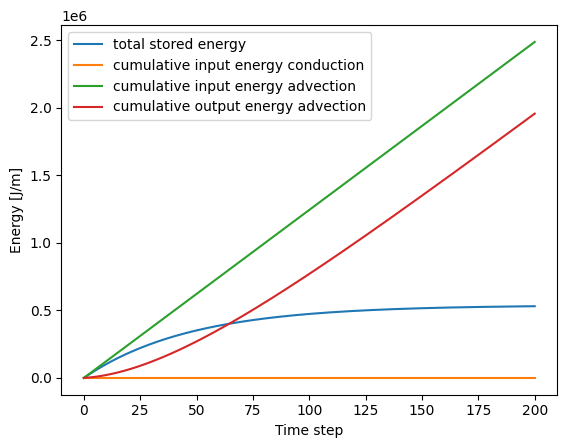

In [25]:
# Plot input and output energies to the system versus stored energy
plt.plot(np.array(E_stored), label = "total stored energy")
plt.plot(np.array(E_input_conduction).cumsum(), label = "cumulative input energy conduction")
plt.plot(np.array(E_input_advection).cumsum(), label = "cumulative input energy advection")
plt.plot(np.array(E_output_advection).cumsum(), label = "cumulative output energy advection")
plt.legend(loc="upper left")
plt.xlabel('Time step')
plt.ylabel('Energy [J/m]')
plt.show()

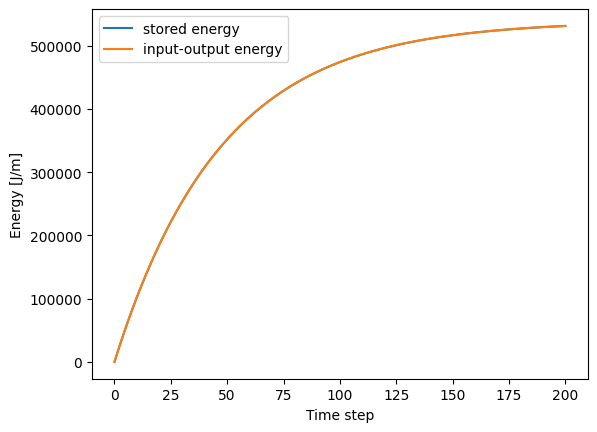

In [26]:
# Plot input-output energies to comparte with stored energy
plt.plot(np.array(E_stored), label = "stored energy")
plt.plot(np.array(E_input_conduction).cumsum()+np.array(E_input_advection).cumsum()-np.array(E_output_advection).cumsum(), label = "input-output energy")
plt.legend(loc="upper left")
plt.xlabel('Time step')
plt.ylabel('Energy [J/m]')
plt.show()

In [27]:
# save data for plotting elsewhere
with open('energy_adv_dominated.npy', 'wb') as f:
#with open('energy_cond_dominated.npy', 'wb') as f:
    np.save(f, np.array(time))
    np.save(f, np.array(E_stored))
    np.save(f, np.array(E_input_conduction).cumsum())
    np.save(f, np.array(E_input_advection).cumsum())
    np.save(f, np.array(E_output_advection).cumsum())

In [28]:
f = fem.Constant(mesh, PETSc.ScalarType(1))
I = fem.form(f * ds(1))
fem.assemble_scalar(I)

7.814167995011862e-07